In [3]:
import datetime
import json
import numpy as np
import time
from pathlib import Path
import pandas as pd
import torch
import torch.backends.cudnn as cudnn
from torch.utils.tensorboard import SummaryWriter
from datetime import date
import timm
# assert timm.__version__ == "0.3.2" # version check
from copy import deepcopy

import os
import sys
sys.path.insert(1, '/mnt/c/Users/PCM/Documents/GitHub/SSL-FL/code')
sys.path.insert(1, '/mnt/c/Users/PCM/Documents/GitHub/SSL-FL/segmenter')
import fed_mae.models_vit as models_vit
from fed_mae.engine_for_finetuning import train_one_epoch
import util.misc as misc

from sklearn.metrics import f1_score

In [4]:
from IPython.display import clear_output 
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import torch
from torchvision.utils import make_grid
from torchvision.io import read_image
# from torchvision import models, transforms
# import sys
# import os
from PIL import Image
import torch
# import torch.functional as F
import numpy as np
clear_output()
# import glob
# from utils import *
from datetime import date
from torch.optim import lr_scheduler
import torchvision
# from constants import mean, std
# from PapilledemaLoader import PapilledemaDataset, PapilSeverityDataset
import torch.nn as nn
import torch.optim as optim

# DiaBetic Retinolpathy

### Dataloader

In [16]:
from torchvision import datasets
from torchvision import  transforms
mean = [0.6821, 0.4575, 0.2626]
std  = [0.1324, 0.1306, 0.1022]

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        # transforms.Resize(256),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

data_dir = '/mnt/c/Users/PCM/Dropbox/ee638/Diabetic'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val',  'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device, class_names)

cuda:0 ['0', '1', '2', '3', '4']


In [17]:
def imshow(inp, title=None, mean=np.array([ 0.7013, -0.1607, -0.7902]), std=np.array([0.5904, 0.5008, 0.3771])):
    """Input shound be tensor [3,224,224]"""
    inp = inp.numpy().transpose((1, 2, 0))
    # mean = mean
    # std = std
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [7]:
len(image_datasets['train'])

22478

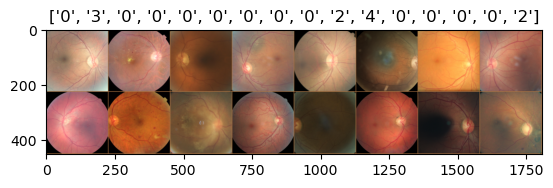

In [18]:
inputs, classes = next(iter(dataloaders['test']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes], mean=mean, std=std)

In [33]:
# ## TEST to load pretrained (SSL-FL) VIT model
mode_fl = 'central' #split1/split2/central
segm = models_vit.__dict__['vit_base_patch16'](
        num_classes=5,
        drop_path_rate=0.1,
        global_pool=True,
        )
state_dict = torch.load(f'./pretrained/SSFL/{mode_fl}/checkpoint-6.pth')
segm.load_state_dict(state_dict['model'], strict=False)

# for param in segm.parameters():
#     param.requires_grad = False

_IncompatibleKeys(missing_keys=['head.weight', 'head.bias', 'fc_norm.weight', 'fc_norm.bias'], unexpected_keys=['mask_token', 'decoder_pos_embed', 'norm.weight', 'norm.bias', 'decoder_embed.weight', 'decoder_embed.bias', 'decoder_blocks.0.norm1.weight', 'decoder_blocks.0.norm1.bias', 'decoder_blocks.0.attn.qkv.weight', 'decoder_blocks.0.attn.qkv.bias', 'decoder_blocks.0.attn.proj.weight', 'decoder_blocks.0.attn.proj.bias', 'decoder_blocks.0.norm2.weight', 'decoder_blocks.0.norm2.bias', 'decoder_blocks.0.mlp.fc1.weight', 'decoder_blocks.0.mlp.fc1.bias', 'decoder_blocks.0.mlp.fc2.weight', 'decoder_blocks.0.mlp.fc2.bias', 'decoder_blocks.1.norm1.weight', 'decoder_blocks.1.norm1.bias', 'decoder_blocks.1.attn.qkv.weight', 'decoder_blocks.1.attn.qkv.bias', 'decoder_blocks.1.attn.proj.weight', 'decoder_blocks.1.attn.proj.bias', 'decoder_blocks.1.norm2.weight', 'decoder_blocks.1.norm2.bias', 'decoder_blocks.1.mlp.fc1.weight', 'decoder_blocks.1.mlp.fc1.bias', 'decoder_blocks.1.mlp.fc2.weight', 

In [34]:
segm = segm.to(device)
momentum = 0.9
lr = 0.01
optimizer_ft = optim.SGD([{'params': segm.head.parameters()}], lr=lr, momentum=momentum)
class_weights=torch.tensor([0.27218792, 2.87651951, 1.3274284 , 8.04293381, 9.92494481],dtype=torch.float).to(device)
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)
scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=4, gamma=0.5)
# warmup_scheduler = warmup.LinearWarmup(optimizer_ft, warmup_period=10)

for param in segm.parameters():
    param.requires_grad = False
# for param in segm.blocks.parameters():
#     param.requires_grad = False
for param in segm.head.parameters():
    param.requires_grad = True

In [36]:
# bestmodel = siamese50simclr
valaccmax = 0
valf1max = 0
for e in range(20):
    training_acc = 0
    val_acc = 0
    training_loss_test = 0.0
    
    for inputs, labels in dataloaders['train']:
        segm.train()
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients

        outputs = segm(inputs)
        # outputs.requires_grad = True
        loss = loss_fn(outputs, labels)
        # loss.requires_grad = True
        optimizer_ft.zero_grad()
        loss.backward()
        optimizer_ft.step()
        with torch.no_grad():
            _, preds = torch.max(outputs, 1)
            training_loss_test += loss.item() * inputs.size(0)
            training_acc += torch.sum(preds == labels.data)


    predlist = []
    labelist = []
    problist = []
    for inputs, labels in dataloaders['val']:
        segm.eval()
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = segm(inputs)
            _, preds = torch.max(outputs, 1)
            # loss = loss_fn(outputs, labels)

        val_acc += torch.sum(preds == labels.data)
        problist.append(outputs[:,1].detach().cpu().numpy())
        labelist.append(labels.detach().cpu().numpy()*1)
        predlist.append(preds.detach().cpu().numpy())
    # sedis = sedis/dataset_sizes['val']
    labelist = np.concatenate(labelist).ravel()
    problist = np.concatenate(problist).ravel()
    predlist = np.concatenate(predlist).ravel()

    val_f1 = f1_score(labelist, predlist, average='weighted')
    today = date.today()

    if(val_acc >= valaccmax):
        valaccmax = val_acc
        print(f"New Acc F1 at epoch {e}")
        torch.save(segm.state_dict(),  f'./pretrained/Diabetic/bestAcc-severity-cls-{mode_fl}-sslfl-{str(today)}.pt')
    # if(sedis <= valaccmin):
    #     torch.save(segm.state_dict(),  f'./pretrained/Diabetic/bestF1-severity-cls-split2-sslfl-{str(today)}.pt')
    if(val_f1 >= valf1max):
        valf1max = val_f1
        print(f"New best F1 at epoch {e}")
        torch.save(segm.state_dict(),  f'./pretrained/Diabetic/bestF1-severity-cls-{mode_fl}-sslfl-{str(today)}.pt')

    # if(val_acc >= valaccmax):
    #     valaccmax = val_acc
    #     print(f"New best mode at epoch {e}")
    #     today = date.today()
    #     torch.save(segm.state_dict(), f'./pretrained/bestacc-severity-cls-split2-sslfl-{str(today)}.pt')
        
    scheduler.step()
    print(f"E{e} With LR {optimizer_ft.param_groups[0]['lr']} training acc: ", training_acc / dataset_sizes['train'], "Val acc: ", val_acc / dataset_sizes['val'], 'Val F1', val_f1, "traning loss: ", training_loss_test / dataset_sizes['train'])

New Acc F1 at epoch 0
New best F1 at epoch 0
E0 With LR 0.01 training acc:  tensor(0.2612, device='cuda:0') Val acc:  tensor(0.1356, device='cuda:0') Val F1 0.04751544989428695 traning loss:  10.582440425115227
New Acc F1 at epoch 1
New best F1 at epoch 1
E1 With LR 0.01 training acc:  tensor(0.2537, device='cuda:0') Val acc:  tensor(0.2416, device='cuda:0') Val F1 0.32440331742945444 traning loss:  10.955468224528762
E2 With LR 0.01 training acc:  tensor(0.2586, device='cuda:0') Val acc:  tensor(0.1046, device='cuda:0') Val F1 0.08548680016491199 traning loss:  10.419061798993798
E3 With LR 0.005 training acc:  tensor(0.2539, device='cuda:0') Val acc:  tensor(0.0649, device='cuda:0') Val F1 0.04114350410648195 traning loss:  11.886205687876306
E4 With LR 0.005 training acc:  tensor(0.2649, device='cuda:0') Val acc:  tensor(0.0865, device='cuda:0') Val F1 0.11112781251981746 traning loss:  5.607812752703754
New Acc F1 at epoch 5
New best F1 at epoch 5
E5 With LR 0.005 training acc:  te

In [1]:
loss

NameError: name 'loss' is not defined

# Preprocessing data, folder

In [ ]:
# Preprocessing data, folder

In [ ]:
import glob
# labels = glob.glob('/mnt/c/Users/PCM/Dropbox/ee638/*')
data = pd.read_csv('/mnt/c/Users/PCM/Dropbox/ee638/train/clinet2_labels.csv')
set(data.level)

{0, 1, 2, 3, 4}

In [ ]:
data[data.level==4]

,image,level
6,16_left,4
7,16_right,4
184,217_left,4
185,217_right,4
252,294_left,4
...,...,...
34914,44100_left,4
35046,44247_left,4
35047,44247_right,4
35048,44249_left,4


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.image, data.level, test_size=0.2, stratify=data.level)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

In [ ]:
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_val = X_val.to_numpy()
y_val = y_val.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

In [ ]:
import shutil

for i in range(len(X_train)):
    try:
        shutil.copy(f"/mnt/c/Users/PCM/Dropbox/ee638/train/client2/{X_train[i]}.jpeg", f"/mnt/c/Users/PCM/Dropbox/ee638/Diabetic/train/{y_train[i]}/{X_train[i]}.jpeg")
    except:
        print(f"No {X_train[i]} found")

for i in range(len(X_val)):
    try:
        shutil.copy(f"/mnt/c/Users/PCM/Dropbox/ee638/train/client2/{X_val[i]}.jpeg", f"/mnt/c/Users/PCM/Dropbox/ee638/Diabetic/val/{y_val[i]}/{X_val[i]}.jpeg")
    except:
        print(f"No {X_val[i]} found")

for i in range(len(X_test)):
    try:
        shutil.copy(f"/mnt/c/Users/PCM/Dropbox/ee638/train/client2/{X_test[i]}.jpeg", f"/mnt/c/Users/PCM/Dropbox/ee638/Diabetic/test/{y_test[i]}/{X_test[i]}.jpeg")
    except:
        print(f"No {X_test[i]} found")

No 16636_right found
No 10_left found
